In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/colab/data_kaggle')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector, ModelBasedImportanceEstimator
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.boost_cb import BoostCB
%matplotlib inline

##1. Data Exploration

In [ ]:
df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
test_id = test_df.index

In [ ]:
(df.isna().sum() / len(df)) * 100

,0
brand,0.000000
model,0.000000
model_year,0.000000
milage,0.000000
fuel_type,2.696080
engine,0.000000
transmission,0.000000
ext_col,0.000000
int_col,0.000000
accident,1.300568


In [ ]:
df.shape

(188533, 12)

##2. Feature Engineering

####colors

In [ ]:
def split_colors(line):
    splited_line = re.findall(r'\w+', line)
    return splited_line

df['colors_ext_new'] = df['ext_col'].apply(split_colors)
df['colors_int_new'] = df['int_col'].apply(split_colors)
test_df['colors_ext_new']  = test_df['ext_col'].apply(split_colors)
test_df['colors_int_new'] = test_df['int_col'].apply(split_colors)

In [4]:
all_colors_list = ['galvanized', 'gray', 'charcoal', 'titanium', 'graphite', 'platinum', 'stone', 'graystone', 'pewter', 'beluga',
                   'shale', 'ash', 'black', 'ebony', 'nero', 'blue', 'navy', 'portland', 'slate', 'ice', 'cobalt', 'white', 'ceramic',
                   'bianco', 'red', 'brandy', 'auburn', 'bordo', 'garnet', 'purple', 'orchid', 'plum', 'brown', 'macchiato', 'tan',
                   'espresso', 'cocoa', 'roast', 'chestnut', 'caramel', 'mocha', 'orange', 'amber', 'beige', 'parchment', 'sandstone',
                   'cappuccino', 'oyster', 'ivory', 'camel', 'cashmere', 'green', 'cypress', 'tupelo', 'gold', 'silver', 'yellow']

In [ ]:
def cut_to_one_color(list_with_colors):
    if len(list_with_colors) == 0:
        one_word = 'no_information'
    else:
        i = 1
        one_word = str()
        for word in list_with_colors:
            if (word.lower() in all_colors_list) == True:
                one_word = word
                return one_word
                break
            elif i<len(list_with_colors):
                i=+1
                continue
            else:
                one_word = 'other'
                return one_word

In [ ]:
df['one_color_int'] = df.apply(lambda x: cut_to_one_color(x['colors_int_new']), axis=1)
df['one_color_ext'] = df.apply(lambda x: cut_to_one_color(x['colors_ext_new']), axis=1)

test_df['one_color_int'] = test_df.apply(lambda x: cut_to_one_color(x['colors_int_new']), axis=1)
test_df['one_color_ext'] = test_df.apply(lambda x: cut_to_one_color(x['colors_ext_new']), axis=1)

####engine

In [ ]:
def engine_divide_columns(line):
    h_power = re.search(r'(\d+\.\d+)HP|(\d+\.\d+)L', line)
    l_capacity = re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', line)
    n_of_cylinders = re.search(r'(\d+) Cylinder', line)

    return (h_power.group(1) if h_power else np.nan, l_capacity.group(1) if l_capacity else np.nan,
n_of_cylinders.group(1) if n_of_cylinders else np.nan)

In [ ]:
df[['h_power', 'l_capacity', 'n_of_cylinders']] = df['engine'].apply(engine_divide_columns).apply(pd.Series)
df[['h_power', 'l_capacity', 'n_of_cylinders']] = df[['h_power', 'l_capacity', 'n_of_cylinders']].astype('float')


test_df[['h_power', 'l_capacity', 'n_of_cylinders']] = test_df['engine'].apply(engine_divide_columns).apply(pd.Series)
test_df[['h_power', 'l_capacity', 'n_of_cylinders']] = test_df[['h_power', 'l_capacity', 'n_of_cylinders']].astype('float')

####car age

In [ ]:
df['car_age'] = df['model_year'].apply(lambda x: 2024 - x)
test_df['car_age'] = test_df['model_year'].apply(lambda x: 2024 - x)

####transmission

In [ ]:
def trasission_divide(line):
    speed = 0
    speed_value = re.search(r'(\d+)-Speed', line)
    if speed_value:
        speed = speed_value.group(1)

    transmission = 'Other'
    if re.search(r'Dual', line, flags = re.IGNORECASE):
        transmission = 'dual'
    elif re.search(r'CVT|Variable', line, flags = re.IGNORECASE):
        transmission = 'continuously-variable'
    elif re.search(r'Electronically Controlled|At/Mt|Fixed Gear', line, flags = re.IGNORECASE):
        transmission = 'semi-automatic'
    elif re.search(r'A/T|Automatic|Overdrive Switch|Automatic with Auto-Shift', line, flags = re.IGNORECASE):
        transmission = 'automatic'
    elif re.search(r'Manual|M/T|Mt', line, flags = re.IGNORECASE):
        transmission = 'manual'

    return speed, transmission

In [ ]:
df[['speed', 'transmission_type']] = df['transmission'].apply(trasission_divide).apply(pd.Series)
df[['speed']] = df[['speed']].astype('int')


test_df[['speed', 'transmission_type']] = test_df['transmission'].apply(trasission_divide).apply(pd.Series)
test_df[['speed']] = test_df[['speed']].astype('float')

In [ ]:
##

##3. Modeling

In [ ]:
def drop_columns(df):
    columns_to_drop = ['ext_col', 'int_col', 'colors_int_new', 'colors_ext_new', 'engine', 'model_year', 'transmission']
    return df.drop(columns_to_drop, axis=1)

df = drop_columns(df)
test_df = drop_columns(test_df)

In [ ]:
X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
categoriacl_f = ['brand', 'model', 'fuel_type', 'transmission_type', 'accident', 'clean_title',
                 'one_color_int', 'one_color_ext']

In [ ]:
from sklearn.model_selection import train_test_split
import category_encoders as ce


encoder = ce.MEstimateEncoder(return_df=True, handle_missing='return_nan')
X_enc = encoder.fit_transform(X[categoriacl_f], y)
#test
test_enc = encoder.transform(test_df[categoriacl_f])

X_final = X.copy()
X_final[X_enc.columns] = X_enc
#test
test_final = test_df.copy()
test_final[test_enc.columns] = test_enc

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, shuffle=True)

## XGBoost

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

iter_imputer = IterativeImputer(initial_strategy = 'median',
                                estimator=LinearRegression(), max_iter=20, min_value=0)

X_train_imp = iter_imputer.fit_transform(X_train)
X_test_imp = iter_imputer.transform(X_test)
test_df_imp = iter_imputer.fit_transform(test_final)

X_train_imp = pd.DataFrame(X_train_imp, columns = X_train.columns)
X_test_imp = pd.DataFrame(X_test_imp, columns = X_test.columns)
test_df_imp = pd.DataFrame(test_df_imp, columns = test_final.columns)

In [ ]:
model = XGBRegressor(
    n_estimators=500,
    objective='reg:absoluteerror',
    max_depth=7,
    learning_rate=0.05,
    eval_metric='rmse',
    early_stopping_rounds=20,
    enable_categorical=True

)
model.fit(X_train_imp, y=y_train, eval_set=[(X_train_imp, y_train), (X_test_imp, y_test)], verbose=50)

[0]	validation_0-rmse:79642.00953	validation_1-rmse:78986.14582
[50]	validation_0-rmse:69045.33444	validation_1-rmse:68099.81812
[100]	validation_0-rmse:56527.01896	validation_1-rmse:55186.51548
[150]	validation_0-rmse:49072.61442	validation_1-rmse:48444.28144
[200]	validation_0-rmse:47812.35884	validation_1-rmse:47119.67066
[250]	validation_0-rmse:46288.87996	validation_1-rmse:46171.06096
[251]	validation_0-rmse:46288.87968	validation_1-rmse:46171.06059


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [ ]:
%%time
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 200, 700)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    booster  = trial.suggest_categorical('booster',  ['gbtree', 'gblinear'])
    sample_type = trial.suggest_categorical('sample_type',  ['uniform', 'weighted'])
    subsample = trial.suggest_loguniform('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.01, 1)
    tree_method = trial.suggest_categorical('tree_method', ['approx', 'hist', 'exact'])
    grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    gamma = trial.suggest_float('gamma', 0, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    #objective = trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror'])


    model = XGBRegressor(
      n_estimators=n_estimators,
      objective='reg:absoluteerror',
      max_depth=max_depth,
      learning_rate=learning_rate,
      booster=booster,
      subsample=subsample,
      colsample_bylevel=colsample_bylevel,
      colsample_bytree=colsample_bytree,
      sample_type=sample_type,
      tree_method=tree_method,
      grow_policy=grow_policy,
      gamma=gamma,
      max_delta_step=max_delta_step,
      reg_alpha=reg_alpha,
      reg_lambda=reg_lambda,
      eval_metric='rmse',
      early_stopping_rounds=20).fit(X=X_train_imp, y=y_train,
                                    eval_set=[(X_train_imp, y_train), (X_test_imp, y_test)], verbose=50)

    #score = cross_validate(model, X_train_2, y_train, cv=3).mean()
    #score = cross_val_score(model, X_train_2, y_train, cv=2, scoring=('neg_mean_absolute_percentage_error')).mean()

    metric = model.evals_result()['validation_1']['rmse'][-1]
    return metric

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

In [ ]:
import xgboost

model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    objective='reg:absoluteerror',
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    booster=best_params['booster'],
    sample_type=best_params['sample_type'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    colsample_bylevel=best_params['colsample_bylevel'],
    tree_method=best_params['tree_method'],
    grow_policy=best_params['grow_policy'],
    gamma=best_params['gamma'],
    max_delta_step=best_params['max_delta_step'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    eval_metric='rmse',
    early_stopping_rounds=20,
    enable_categorical=True

)
model.fit(X=X_train_imp, y=y_train, eval_set=[(X_train_imp, y_train), (X_test_imp, y_test)], verbose=50)
#print('train: ', rm(y_train, model.predict(X_train)))
#print('test: ', mape(y_test, model.predict(X_test)))

[0]	validation_0-rmse:79475.08293	validation_1-rmse:79009.87123


C:\Users\bogho\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_type" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:55345.05091	validation_1-rmse:54161.72043
[100]	validation_0-rmse:36945.83019	validation_1-rmse:36631.74404
[150]	validation_0-rmse:30764.02755	validation_1-rmse:32158.72922
[200]	validation_0-rmse:27675.57334	validation_1-rmse:30672.43819
[250]	validation_0-rmse:23438.71848	validation_1-rmse:29816.24572
[269]	validation_0-rmse:23013.73026	validation_1-rmse:29910.93879


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5382926277299587, colsample_bynode=None,
             colsample_bytree=0.6248512566111324, device=None,
             early_stopping_rounds=20, enable_categorical=True,
             eval_metric='rmse', feature_types=None, gamma=0.2710227085597462,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.0794061384087671,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=1.5535327905297214, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=394, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

## LightAutoML

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
N_THREADS = 8
TIMEOUT = 3600
CV = 4
TARGET = ['price']

train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)

task = Task('reg', metric=root_mean_squared_error, greater_is_better=False)
roles = {'target': TARGET}

In [ ]:
%%time
automl = TabularAutoML(task=task, timeout=TIMEOUT, cpu_limit=N_THREADS, reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE, 'cv': CV})

train_predict = automl.fit_predict(train, roles=roles, verbose=5)
print(f'train score: {mse(train[TARGET], train_predict.data[:, 0], squared=False)}')

test_predict = automl.predict(test)
print(f'test score: {mse(test[TARGET], test_predict.data[:, 0], squared=False)}')

train score: 75165.25667746915

test score: 66083.37121361573

    Final prediction for new objects (level 0) =

	 0.40058 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +

	 0.14081 * (4 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +

	 0.45861 * (4 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost)

<Axes: xlabel='Feature'>

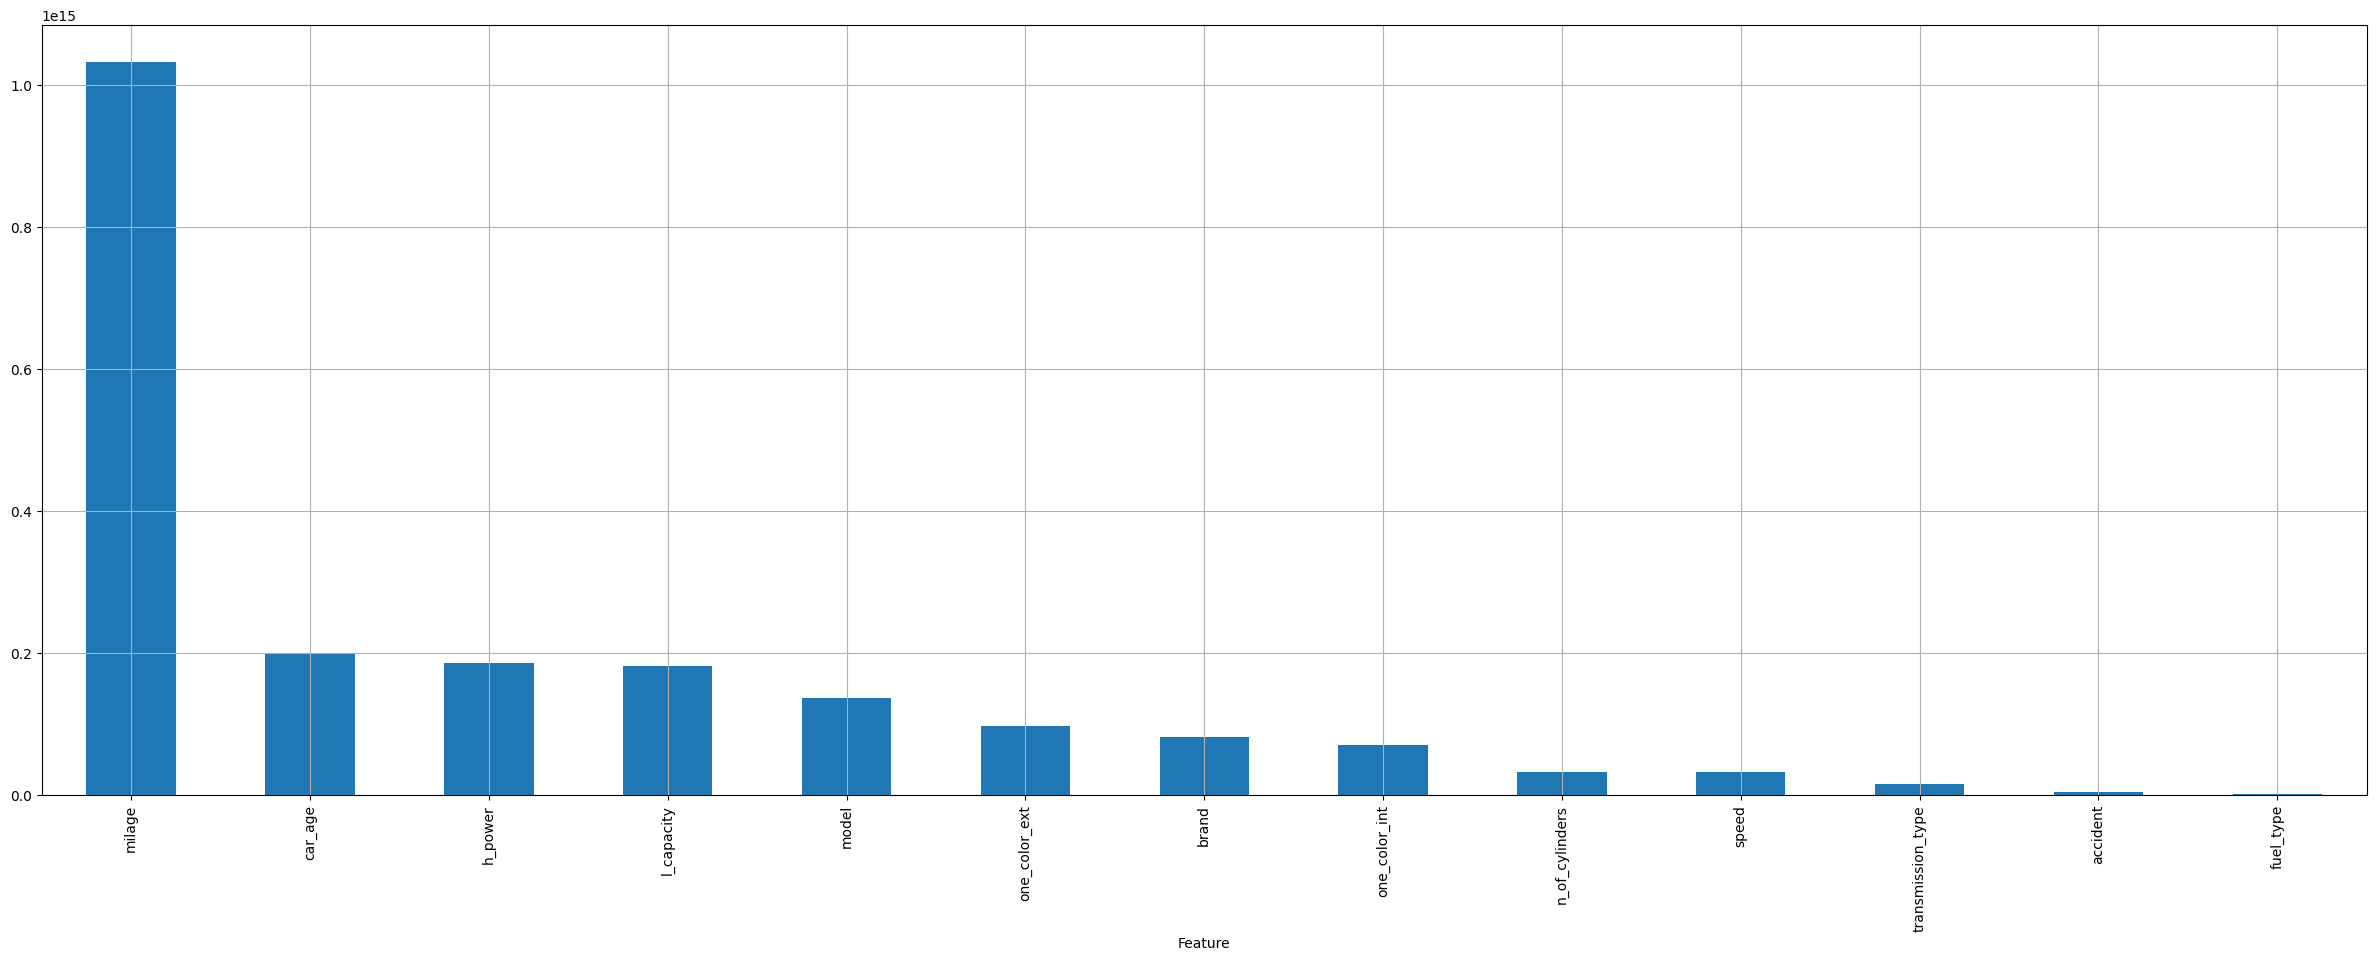

In [ ]:
fast_fi = automl.get_feature_scores()
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

CPU times: user 1min 43s, sys: 545 ms, total: 1min 43s
Wall time: 1min 15s


<Axes: xlabel='Feature'>

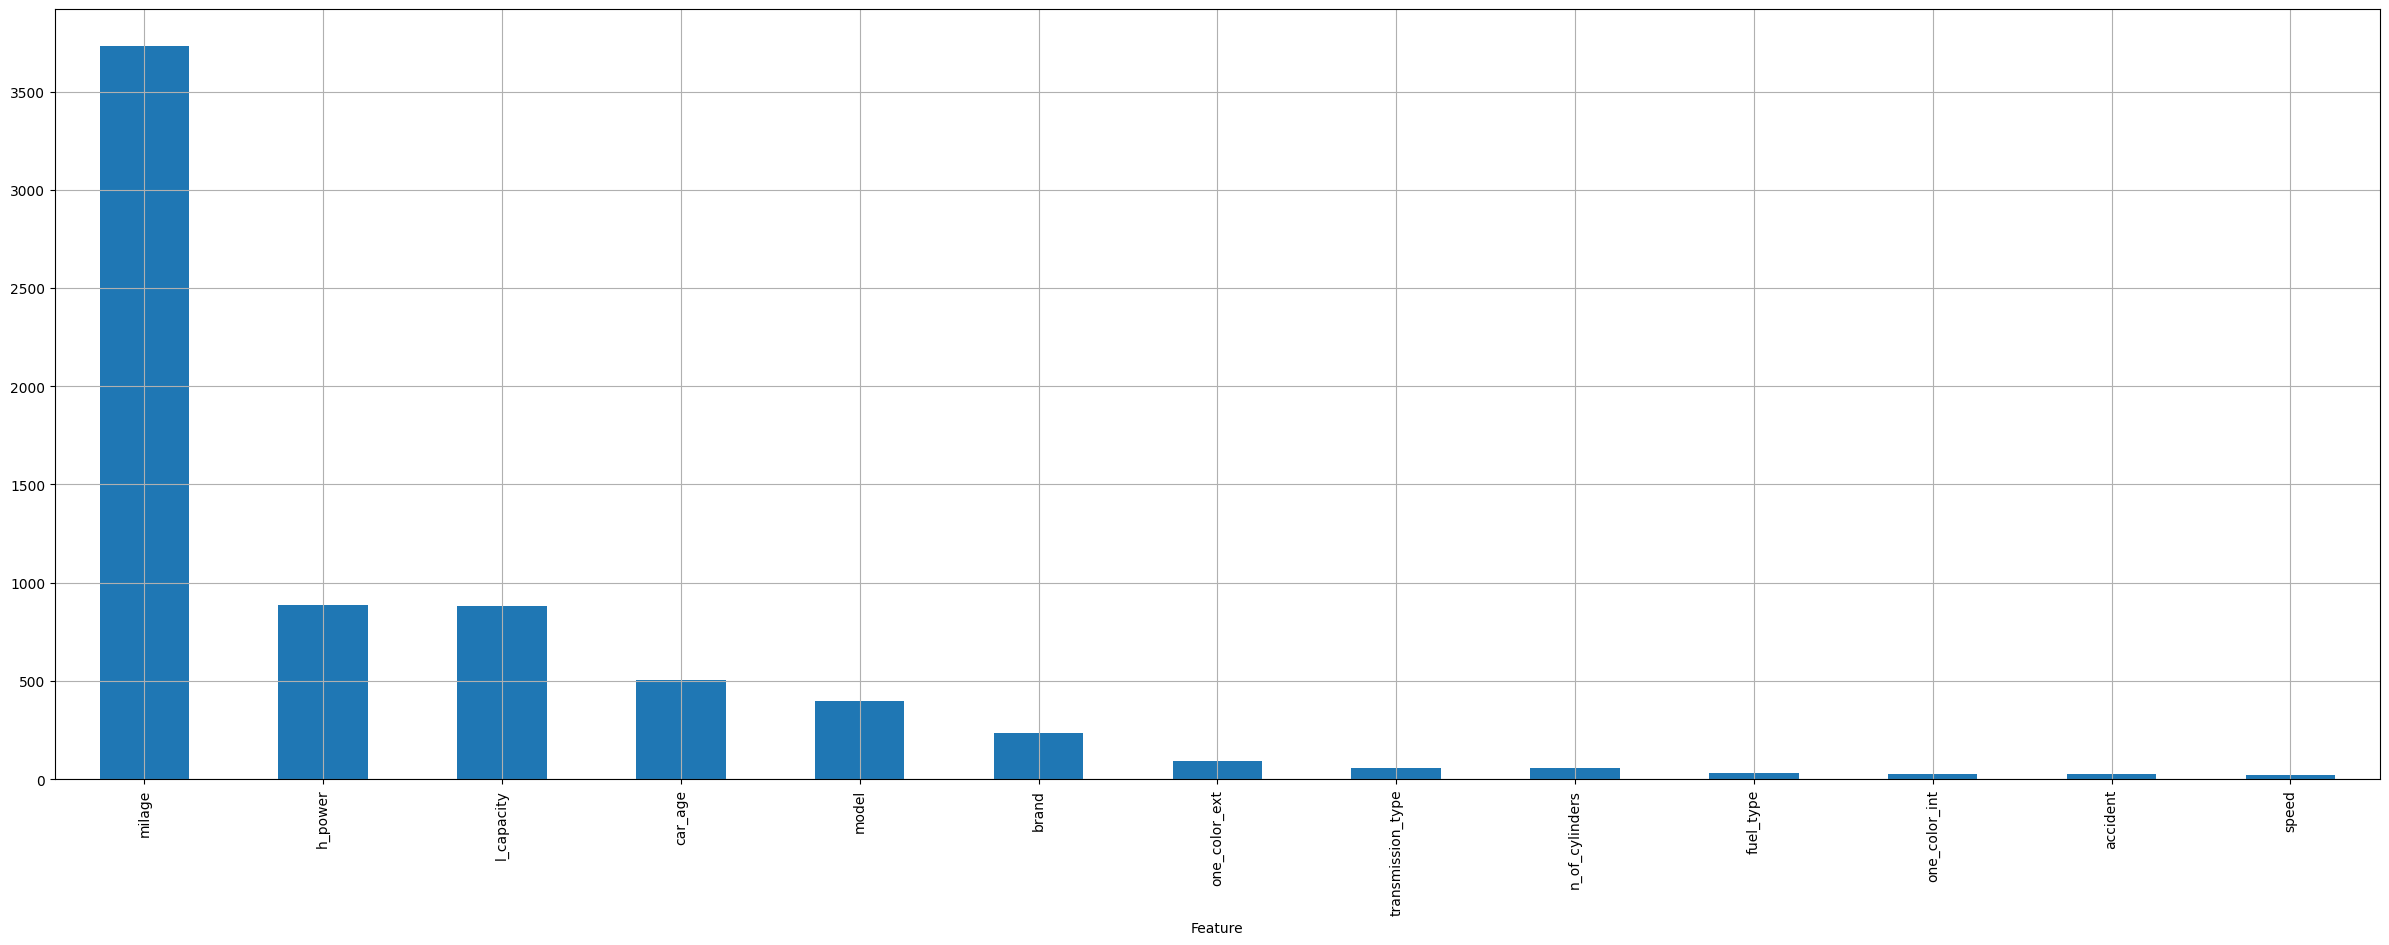

In [ ]:
%%time
accurate_fi = automl.get_feature_scores('accurate', test, silent = True)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

##Pipe_automl

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
N_THREADS = 8
TIMEOUT = 3600
CV = 4
TARGET = ['price']

train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)

task = Task('reg', metric=root_mean_squared_error, greater_is_better=False)
roles = {'target': TARGET}

reader = PandasToPandasReader(task, cv=CV, random_state=RANDOM_STATE)

In [ ]:
#pipe1
mbie = ModelBasedImportanceEstimator()
pipe0 = LGBSimpleFeatures()
model0_lvl1 = BoostLGBM(default_params={'learning_rate': 0.05, 'num_leaves': 128, 'seed': RANDOM_STATE, 'num_threads': N_THREADS})
selector_lvl1 = ImportanceCutoffSelector(pipe0, model0_lvl1, mbie, cutoff=0)

pipe1 = LGBSimpleFeatures()
param_tuner1_lvl1 = OptunaTuner(n_trials=30, timeout=360)
model1_lvl1 = BoostLGBM(default_params={'learning_rate': 0.05, 'num_leaves': 128, 'seed': RANDOM_STATE, 'num_threads': N_THREADS})
#model2_lvl1 = BoostLGBM(default_params={'learning_rate': 0.025, 'num_leaves': 64, 'seed': RANDOM_STATE, 'num_threads': N_THREADS})

pipeline_lvl1 = MLPipeline([
    model0_lvl1,
    (model1_lvl1, param_tuner1_lvl1)],
                          pre_selection=selector_lvl1, features_pipeline=pipe1, post_selection=None)


#pipe2
pipe2 = LGBSimpleFeatures()
model0_lvl2 = BoostLGBM(default_params={'learning_rate': 0.05, 'num_leaves': 64, 'max_bin': 1024, 'seed': 3, 'num_threads': N_THREADS},
    freeze_defaults=True)

model0_lvl2 = BoostLGBM()
param_tuner1_lvl2 = OptunaTuner(n_trials=100, timeout=1000)

model0_lvl3 = BoostCB()
param_tuner2_lvl2 = OptunaTuner(n_trials=100, timeout=1000)

pipeline_lvl2 = MLPipeline([model0_lvl2, (model0_lvl2, param_tuner1_lvl2), (model0_lvl3, param_tuner2_lvl2)],
                           pre_selection=None, features_pipeline=pipe2, post_selection=None)


automl = AutoML(reader, [[pipeline_lvl1], [pipeline_lvl2]], skip_conn=True)

In [ ]:
%%time
pipe_model = automl.fit_predict(train, roles=roles, verbose=3)

In [ ]:
print(f'train score: {root_mean_squared_error(train[TARGET].values, pipe_model.data[:, 0])}')
test_pred = automl.predict(test)
print(f'test score: {root_mean_squared_error(test[TARGET].values, test_pred.data[:, 0])}')

train score: 75718.39390686358
test score: 66126.52439719552


In [ ]:
prediction = automl.predict(test_df)
pd.DataFrame({'id': test_id, 'price': prediction.data[:, 0]}).set_index('id').to_csv('pred_tabular.csv')